In [21]:
from numpy import save, load
from pandas import read_csv
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras import Model
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense,Activation
from keras.models import Input, Model
from keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,GlobalAveragePooling1D,TimeDistributed, MaxPooling1D
import tensorflow as tf
import numpy as np
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
x_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/Dataset1/trainX.npy')
y_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/Dataset1/trainy.npy')
x_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/Dataset1/testX.npy')
y_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/Dataset1/testy.npy')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/gdrive
(33104, 128, 3) (33104, 118) (3740, 128, 3) (3740, 118)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [4]:
def channel_normalization(x):
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out

def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x

In [7]:
class TCN:

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding
        
        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        if self.dilations is None:
            self.dilations = [1, 2, 4, 8, 16, 32]
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x

In [8]:
input_shape = x_train.shape[1:]
input = Input(shape=x_train.shape[1:])
x = SpatialDropout1D(0.2)(input)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc1')(x)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc2')(x)
max_pool = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(max_pool)
x = Dropout(0.2)(x)
output = Dense(118, activation="softmax")(x)    
model = Model(inputs=input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 3)]     0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 128, 3)      0           ['input_1[0][0]']                
 out1D)                                                                                           
                                                                                                  
 tnc1_initial_conv (Conv1D)     (None, 128, 128)     512         ['spatial_dropout1d[0][0]']      
                                                                                                  
 tnc1_dilated_conv_1_tanh_s0 (C  (None, 128, 128)    49280       ['tnc1_initial_conv[0][0]']  

In [9]:
history = model.fit(x_train, y_train, epochs=200, verbose=True, validation_data=(x_validation, y_validation), batch_size=128,callbacks=callbacks)

Epoch 1/200
166/166 [==============================] - 44s 176ms/step - loss: 3.2663 - accuracy: 0.2546 - val_loss: 1.3197 - val_accuracy: 0.7157
Epoch 2/200
166/166 [==============================] - 27s 161ms/step - loss: 1.5525 - accuracy: 0.6133 - val_loss: 0.5796 - val_accuracy: 0.8614
Epoch 3/200
166/166 [==============================] - 27s 160ms/step - loss: 1.0363 - accuracy: 0.7378 - val_loss: 0.3908 - val_accuracy: 0.9101
Epoch 4/200
166/166 [==============================] - 27s 160ms/step - loss: 0.8252 - accuracy: 0.7915 - val_loss: 0.3654 - val_accuracy: 0.9107
Epoch 5/200
166/166 [==============================] - 27s 160ms/step - loss: 0.6963 - accuracy: 0.8208 - val_loss: 0.3209 - val_accuracy: 0.9152
Epoch 6/200
166/166 [==============================] - 27s 164ms/step - loss: 0.6086 - accuracy: 0.8434 - val_loss: 0.3047 - val_accuracy: 0.9143
Epoch 7/200
166/166 [==============================] - 26s 160ms/step - loss: 0.5370 - accuracy: 0.8604 - val_loss: 0.2206 -

In [10]:
loss, accuracy = model.evaluate(x_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9651
Testing Accuracy: 0.9131


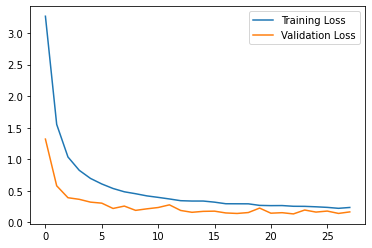

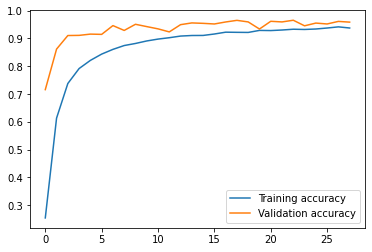

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()

In [22]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
for train_ix, test_ix in kfold.split(x_validation, y_validation):
	# select rows
	x_train, x_test = x_validation[train_ix], x_validation[test_ix]
	y_train, y_test = y_validation[train_ix], y_validation[test_ix]
	# summarize train and test composition
	train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
	test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
	print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

AttributeError: ignored

In [15]:
x = x_validation                        
 
# Input_ y_Target_Variable.
y = y_validation                     
   
nsamples, nx, ny = x_train.shape
d2_train_dataset = x_train.reshape((nsamples,nx*ny))
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
  
# Create  classifier object.
lr = linear_model.LogisticRegression()
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(x_train, y_train)
    lst_accu_stratified.append(lr.score(x_test, y_test))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

ValueError: ignored